In [46]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers,models


#打印日志
def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(info+'...\n\n')


    


In [57]:
#================================================================================
# 一，构建数据管道
#================================================================================
printlog("step1: prepare dataset...")


dftrain_raw = pd.read_csv("./data/titanic/train.csv")
dftest_raw = pd.read_csv("./data/titanic/test.csv")

dfraw = pd.concat([dftrain_raw,dftest_raw])

def prepare_dfdata(dfraw):
    dfdata = dfraw.copy()
    dfdata.columns = [x.lower() for x in dfdata.columns]
    dfdata = dfdata.rename(columns={'survived':'label'})
    dfdata = dfdata.drop(['passengerid','name'],axis = 1)
    for col,dtype in dict(dfdata.dtypes).items():
        # 判断是否包含缺失值
        if dfdata[col].hasnans:
            # 添加标识是否缺失列
            dfdata[col + '_nan'] = pd.isna(dfdata[col]).astype('int32')
            # 填充
            if dtype not in [np.object,np.str,np.unicode]:
                dfdata[col].fillna(dfdata[col].mean(),inplace = True)
            else:
                dfdata[col].fillna('',inplace = True)
    return(dfdata)

dfdata = prepare_dfdata(dfraw)
dftrain = dfdata.iloc[0:len(dftrain_raw),:]
dftest = dfdata.iloc[len(dftrain_raw):,:]



# 从 dataframe 导入数据 
def df_to_dataset(df, shuffle=True, batch_size=32):
    dfdata = df.copy()
    if 'label' not in dfdata.columns:
        ds = tf.data.Dataset.from_tensor_slices(dfdata.to_dict(orient = 'list'))
    else: 
        labels = dfdata.pop('label')
        ds = tf.data.Dataset.from_tensor_slices((dfdata.to_dict(orient = 'list'), labels))  
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dfdata))
    ds = ds.batch(batch_size)
    return ds

ds_train = df_to_dataset(dftrain)
ds_test = df_to_dataset(dftest)



================================================================================2021-11-24 13:59:59
step1: prepare dataset......




In [55]:
ds_test 

<BatchDataset shapes: ({pclass: (None,), sex: (None,), age: (None,), sibsp: (None,), parch: (None,), ticket: (None,), fare: (None,), cabin: (None,), embarked: (None,), age_nan: (None,), cabin_nan: (None,), embarked_nan: (None,)}, (None,)), types: ({pclass: tf.int32, sex: tf.string, age: tf.float32, sibsp: tf.int32, parch: tf.int32, ticket: tf.string, fare: tf.float32, cabin: tf.string, embarked: tf.string, age_nan: tf.int32, cabin_nan: tf.int32, embarked_nan: tf.int32}, tf.int64)>

In [51]:
#================================================================================
# 二，定义特征列
#================================================================================
printlog("step2: make feature columns...")

feature_columns = []

# 数值列
for col in ['age','fare','parch','sibsp'] + [
    c for c in dfdata.columns if c.endswith('_nan')]:
    feature_columns.append(tf.feature_column.numeric_column(col))

# 分桶列
age = tf.feature_column.numeric_column('age')
age_buckets = tf.feature_column.bucketized_column(age, 
             boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)

# 类别列
# 注意：所有的Catogorical Column类型最终都要通过indicator_column转换成Dense Column类型才能传入模型！！
sex = tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(
      key='sex',vocabulary_list=["male", "female"]))
feature_columns.append(sex)

pclass = tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(
      key='pclass',vocabulary_list=[1,2,3]))
feature_columns.append(pclass)

ticket = tf.feature_column.indicator_column(
     tf.feature_column.categorical_column_with_hash_bucket('ticket',3))
feature_columns.append(ticket)

embarked = tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(
      key='embarked',vocabulary_list=['S','C','B']))
feature_columns.append(embarked)

# 嵌入列
cabin = tf.feature_column.embedding_column(
    tf.feature_column.categorical_column_with_hash_bucket('cabin',32),2)
feature_columns.append(cabin)

# 交叉列
pclass_cate = tf.feature_column.categorical_column_with_vocabulary_list(
          key='pclass',vocabulary_list=[1,2,3])

crossed_feature = tf.feature_column.indicator_column(
    tf.feature_column.crossed_column([age_buckets, pclass_cate],hash_bucket_size=15))

feature_columns.append(crossed_feature)


================================================================================2021-11-24 13:58:32
step2: make feature columns......




In [52]:
feature_columns

[NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='fare', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='parch', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='sibsp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='age_nan', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='cabin_nan', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='embarked_nan', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 BucketizedColumn(source_column=NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(18, 25, 30, 35, 40, 45, 50, 55, 60, 65)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), 

In [48]:
#================================================================================
# 三，定义模型
#================================================================================
printlog("step3: define model...")

tf.keras.backend.clear_session()
model = tf.keras.Sequential([
  layers.DenseFeatures(feature_columns), #将特征列放入到tf.keras.layers.DenseFeatures中!!!
  layers.Dense(64, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])


================================================================================2021-11-24 13:56:06
step3: define model......




In [58]:
#================================================================================
# 四，训练模型
#================================================================================
printlog("step4: train model...")

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(ds_train,
          validation_data=ds_test,
          epochs=50)


================================================================================2021-11-24 14:02:42
step4: train model......


Epoch 1/50
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
18/23 [======================>.......] - ETA: 0s - loss: 0.5332 - accuracy: 0.7656 WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'pclass': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=int32>, 'sex': <tf.Tensor 'ExpandDims_9:0' shape=(None, 1) dtype=string>, 'age': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float32>, 'sibsp': <tf.Tensor 'ExpandDims_10:0' shape=(None, 1) dtype=int32>, 'parch': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=int32>, 'ticket': <tf.Tensor 'ExpandDims_11:0' shape=(None, 1) dtype=string>, 'fare': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=float32>, 'cabin': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=string>, 

23/23 [==============================] - 0s 5ms/step - loss: 0.3859 - accuracy: 0.8287 - val_loss: 0.4412 - val_accuracy: 0.7877
Epoch 37/50
23/23 [==============================] - 0s 5ms/step - loss: 0.3793 - accuracy: 0.8413 - val_loss: 0.4634 - val_accuracy: 0.7821
Epoch 38/50
23/23 [==============================] - 0s 5ms/step - loss: 0.3950 - accuracy: 0.8258 - val_loss: 0.4470 - val_accuracy: 0.7989
Epoch 39/50
23/23 [==============================] - 0s 6ms/step - loss: 0.3849 - accuracy: 0.8441 - val_loss: 0.4409 - val_accuracy: 0.7989
Epoch 40/50
23/23 [==============================] - 0s 6ms/step - loss: 0.3740 - accuracy: 0.8427 - val_loss: 0.4319 - val_accuracy: 0.8101
Epoch 41/50
23/23 [==============================] - 0s 6ms/step - loss: 0.3696 - accuracy: 0.8455 - val_loss: 0.4492 - val_accuracy: 0.7821
Epoch 42/50
23/23 [==============================] - 0s 7ms/step - loss: 0.3631 - accuracy: 0.8455 - val_loss: 0.4546 - val_accuracy: 0.7877
Epoch 43/50
23/23 [======


================================================================================2021-11-24 14:02:52
step5: eval model......


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  64        
_________________________________________________________________
dense (Dense)                multiple                  3008      
_________________________________________________________________
dense_1 (Dense)              multiple                  4160      
_________________________________________________________________
dense_2 (Dense)              multiple                  65        
Total params: 7,297
Trainable params: 7,297
Non-trainable params: 0
_________________________________________________________________


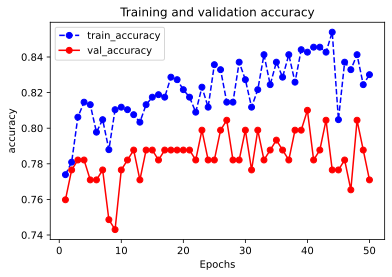

In [59]:
#================================================================================
# 五，评估模型
#================================================================================
printlog("step5: eval model...")

model.summary()


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

plot_metric(history,"accuracy")

In [60]:
#zip:将两个长度相同的Dataset横向铰合。

ds1 = tf.data.Dataset.range(0,3)
ds2 = tf.data.Dataset.range(3,6)
ds3 = tf.data.Dataset.range(6,9)
ds_zip = tf.data.Dataset.zip((ds1,ds2,ds3))
for x,y,z in ds_zip:
    print(x.numpy(),y.numpy(),z.numpy())

0 3 6
1 4 7
2 5 8


In [61]:
ds1

<RangeDataset shapes: (), types: tf.int64>

In [62]:
ds2

<RangeDataset shapes: (), types: tf.int64>

In [63]:
ds3

<RangeDataset shapes: (), types: tf.int64>

In [64]:
#condatenate:将两个Dataset纵向连接。

ds1 = tf.data.Dataset.range(0,3)
ds2 = tf.data.Dataset.range(3,6)
ds_concat = tf.data.Dataset.concatenate(ds1,ds2)
for x in ds_concat:
    print(x)


tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)


In [65]:
#reduce:执行归并操作。

ds = tf.data.Dataset.from_tensor_slices([1,2,3,4,5.0])
result = ds.reduce(0.0,lambda x,y:tf.add(x,y))
result

<tf.Tensor: shape=(), dtype=float32, numpy=15.0>

In [66]:
#batch:构建批次，每次放一个批次。比原始数据增加一个维度。 其逆操作为unbatch。 

ds = tf.data.Dataset.range(12)
ds_batch = ds.batch(4)
for x in ds_batch:
    print(x)

tf.Tensor([0 1 2 3], shape=(4,), dtype=int64)
tf.Tensor([4 5 6 7], shape=(4,), dtype=int64)
tf.Tensor([ 8  9 10 11], shape=(4,), dtype=int64)


In [67]:
#padded_batch:构建批次，类似batch, 但可以填充到相同的形状。

elements = [[1, 2],[3, 4, 5],[6, 7],[8]]
ds = tf.data.Dataset.from_generator(lambda: iter(elements), tf.int32)

ds_padded_batch = ds.padded_batch(2,padded_shapes = [3,])
for x in ds_padded_batch:
    print(x)    

tf.Tensor(
[[1 2 0]
 [3 4 5]], shape=(2, 3), dtype=int32)
tf.Tensor(
[[6 7 0]
 [8 0 0]], shape=(2, 3), dtype=int32)


In [68]:
#window:构建滑动窗口，返回Dataset of Dataset.

ds = tf.data.Dataset.range(12)
#window返回的是Dataset of Dataset,可以用flat_map压平
ds_window = ds.window(4, shift=1).flat_map(lambda x: x.batch(4,drop_remainder=True)) 
for x in ds_window:
    print(x)

tf.Tensor([0 1 2 3], shape=(4,), dtype=int64)
tf.Tensor([1 2 3 4], shape=(4,), dtype=int64)
tf.Tensor([2 3 4 5], shape=(4,), dtype=int64)
tf.Tensor([3 4 5 6], shape=(4,), dtype=int64)
tf.Tensor([4 5 6 7], shape=(4,), dtype=int64)
tf.Tensor([5 6 7 8], shape=(4,), dtype=int64)
tf.Tensor([6 7 8 9], shape=(4,), dtype=int64)
tf.Tensor([ 7  8  9 10], shape=(4,), dtype=int64)
tf.Tensor([ 8  9 10 11], shape=(4,), dtype=int64)


In [69]:
#shuffle:数据顺序洗牌。

ds = tf.data.Dataset.range(12)
ds_shuffle = ds.shuffle(buffer_size = 5)
for x in ds_shuffle:
    print(x)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(11, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)


In [70]:
#repeat:重复数据若干次，不带参数时，重复无数次。

ds = tf.data.Dataset.range(3)
ds_repeat = ds.repeat(2)
for x in ds_repeat:
    print(x)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)


In [71]:
#shard:采样，从某个位置开始隔固定距离采样一个元素。

ds = tf.data.Dataset.range(12)
ds_shard = ds.shard(3,index = 1)

for x in ds_shard:
    print(x)

tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)


In [72]:
#take:采样，从开始位置取前几个元素。

ds = tf.data.Dataset.range(12)
ds_take = ds.take(3)

list(ds_take.as_numpy_iterator())

[0, 1, 2]